# Importing the required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Loading the dataset

In [2]:
df = pd.read_csv("./Dataset/breast-cancer-wisconsin.data")

Assigning column names to the dataset

In [3]:
df.columns = ["id_number", "clump_thickness", "uniformity_of_cell_size", "uniformity_of_cell_shape", "marginal_adhesion", "single_epithelial_cell_size", 
              "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]

**Changing the target (class) to 0 and 1 instead of 2 and 4**

Alternatively, you can use `df['class'].replace([2, 4], [0, 2], inplace=True)` to achieve the same results

In [4]:
df['class'] = pd.Series(pd.Categorical(df['class']).codes)

In [5]:
df.head()

,id_number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1002945,5,4,4,5,7,10,3,2,1,0
1,1015425,3,1,1,1,2,2,3,1,1,0
2,1016277,6,8,8,1,3,4,3,7,1,0
3,1017023,4,1,1,3,2,1,3,1,1,0
4,1017122,8,10,10,8,7,10,9,7,1,1


## Converting categorical columns to numeric and replacing null values with the mean

In [6]:
df['bare_nuclei'] = pd.to_numeric(df['bare_nuclei'], errors='coerce')

In [7]:
df['bare_nuclei'] = df['bare_nuclei'].fillna(value=round(df['bare_nuclei'].mean()))

In [8]:
df.isna().sum()

id_number                      0
clump_thickness                0
uniformity_of_cell_size        0
uniformity_of_cell_shape       0
marginal_adhesion              0
single_epithelial_cell_size    0
bare_nuclei                    0
bland_chromatin                0
normal_nucleoli                0
mitoses                        0
class                          0
dtype: int64

In [9]:
df.dtypes

id_number                        int64
clump_thickness                  int64
uniformity_of_cell_size          int64
uniformity_of_cell_shape         int64
marginal_adhesion                int64
single_epithelial_cell_size      int64
bare_nuclei                    float64
bland_chromatin                  int64
normal_nucleoli                  int64
mitoses                          int64
class                             int8
dtype: object

# Splitting the dataset into the features (X) and target (y)
Dropping the id_number column since it has no effect on the target variable



In [10]:
X = df.drop(["id_number", "class"], axis=1)
y = df['class']

In [11]:
X = np.array(X)
y = df['class'].values.reshape(X.shape[0], 1)

# Implementation of the Artificial Neural Network

In [13]:
from collections import defaultdict
from numpy.random import randn
from sklearn.model_selection import cross_validate


class ANN():        
    def __init__(self, layers=[9,4,1], learning_rate=1e-3, max_iter=1000):
        self.X = X
        self.y = y
        self.network_parameters = defaultdict(float)
        self.learning_rate = learning_rate
        self.layers = layers
        self.max_iter = max_iter
        self.loss = []
        self.sample_size = None

    def get_params(self, deep=False):
        hyper_params = {
           "layers": self.layers,
           "learning_rate": self.learning_rate,
           "max_iter": self.max_iter
       }
        return hyper_params
                
    def randomly_initialize_weights(self):
        # Randomly initialize the weights and bias
        np.random.seed(1) # Setting the random number seed
        self.network_parameters["W1"] = randn(self.layers[0], self.layers[1]) 
        self.network_parameters['b1'] = randn(self.layers[1],)
        self.network_parameters['W2'] = randn(self.layers[1],self.layers[2]) 
        self.network_parameters['b2'] = randn(self.layers[2],)
    
    def relu(self, nd_arr):
        # Eliminate negative values by replacing any value less than 0 (in nd_arr) with 0
        nd_arr[np.where(nd_arr<0)] = 0
        return nd_arr

    def dRelu(self, nd_arr):
        # Set values in the numpy array greater <= 0 with 0, otherwise 1
        nd_arr[np.where(nd_arr<=0)] = 0
        nd_arr[np.where(nd_arr>0)] = 1
        return nd_arr

    def sigmoid(self, nd_arr):
        # Scale input in the numpy array to a range between 0 and 1
        return 1 / (1 + np.exp(-nd_arr))
        
    def cross_entropy_loss_function(self,y, y_pred):
        y_pred_inv = 1.0 - y_pred
        y_inv = 1.0 - y
        loss = -1/len(y) * (np.sum(np.multiply(np.log(y_pred), y) + np.multiply((y_inv), np.log(y_pred_inv))))
        return loss

    def feed_forward(self):
        # Feed Forward Propagation
        weighted_sum1 = self.X.dot(self.network_parameters['W1']) + self.network_parameters['b1']
        output = self.relu(weighted_sum1)
        weighted_sum2 = output.dot(self.network_parameters['W2']) + self.network_parameters['b2']
        y_pred = self.sigmoid(weighted_sum2)
        loss = self.cross_entropy_loss_function(self.y, y_pred)

        # save calculated parameters     
        self.network_parameters['weighted_sum1'] = weighted_sum1
        self.network_parameters['weighted_sum2'] = weighted_sum2
        self.network_parameters['output'] = output

        return y_pred, loss

    def back_propagation(self,y_pred):
        #Backward Propagation
        #wrt stands for with respect to
        y_inv = 1 - self.y
        y_pred_inv = 1 - y_pred

        loss_derivative_wrt_ypred = np.divide(y_inv, y_pred_inv) - np.divide(self.y, y_pred)
        loss_derivative_wrt_sigmoid = y_pred * (y_pred_inv)
        loss_derivative_wrt_weighted_sum2 = loss_derivative_wrt_ypred * loss_derivative_wrt_sigmoid

        loss_derivative_wrt_output = loss_derivative_wrt_weighted_sum2.dot(self.network_parameters['W2'].T)
        loss_derivative_wrt_w2 = self.network_parameters['output'].T.dot(loss_derivative_wrt_weighted_sum2)
        loss_derivative_wrt_b2 = np.sum(loss_derivative_wrt_weighted_sum2, axis=0, keepdims=True)

        loss_derivative_wrt_weighted_sum1 = loss_derivative_wrt_output * self.dRelu(self.network_parameters['weighted_sum1'])
        loss_derivative_wrt_w1 = self.X.T.dot(loss_derivative_wrt_weighted_sum1)
        loss_derivative_wrt_b1 = np.sum(loss_derivative_wrt_weighted_sum1, axis=0, keepdims=True)

        #update the weights and bias
        self.network_parameters['W1'] = self.network_parameters['W1'] - self.learning_rate * loss_derivative_wrt_w1
        self.network_parameters['W2'] = self.network_parameters['W2'] - self.learning_rate * loss_derivative_wrt_w2
        self.network_parameters['b1'] = self.network_parameters['b1'] - self.learning_rate * loss_derivative_wrt_b1
        self.network_parameters['b2'] = self.network_parameters['b2'] - self.learning_rate * loss_derivative_wrt_b2

    def fit(self, X, y):
        # Training the Neural Network
        self.X = X
        self.y = y
        self.randomly_initialize_weights() #initialize weights and bias

        for _ in range(self.max_iter):
            y_pred, loss = self.feed_forward()
            self.back_propagation(y_pred)
            self.loss.append(loss)

    def predict(self, X):
        # Making predictions
        weighted_sum1 = X.dot(self.network_parameters['W1']) + self.network_parameters['b1']
        output = self.relu(weighted_sum1)
        weighted_sum2 = output.dot(self.network_parameters['W2']) + self.network_parameters['b2']
        pred = self.sigmoid(weighted_sum2)
        return np.round(pred) 

    def acc(self, y, y_pred):
        # Compute accuray
        acc = sum(y == y_pred) / len(y) * 100
        return round(acc[0], 4)


    def plot_loss(self):
        # Plot loss curve
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()  

    def plot_accuracy(self):
        _scoring = ['accuracy', 'precision', 'recall']
        k_folds = 4
        results = cross_validate( 
                          estimator=model,
                          X=self.X,
                          y=self.y,
                          cv=k_folds,
                          scoring=_scoring,
                          return_train_score=True)
        plt.figure(figsize=(8, 6))
        plt.plot(results['test_accuracy'], label="Test Accuracy")
        plt.plot(results['train_accuracy'], label="Train Accuracy")
        plt.xlabel("Number of epochs", fontdict={"fontsize": 16})
        plt.ylabel("Accuracy", fontdict={"fontsize": 16})
        plt.title("Accuray vs Number of Epochs", fontdict={"fontsize": 20})
        plt.legend(loc="best")
        plt.show()

# Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Instantiating the Neural Network

In [16]:
model = ANN(layers=[9, 4, 1], learning_rate=0.0001, max_iter=10000) 

## Using Cross Validation with 4 k-folds

In [17]:
from sklearn.model_selection import cross_validate
_scoring = ['accuracy', 'precision', 'recall']
results = cross_validate( estimator=model,
                          X=X_train,
                          y=y_train,
                          cv=4,
                          scoring=_scoring,
                          return_train_score=False)

In [18]:
for key, value in results.items():
    print(f"{key}: {value}")

fit_time: [3.0000596  2.47699499 2.3913548  2.51111865]
score_time: [0.00291204 0.00273013 0.00262713 0.00297999]
test_accuracy: [0.92366412 0.95419847 0.95419847 0.99230769]
test_precision: [0.87804878 0.90196078 0.95348837 1.        ]
test_recall: [0.87804878 0.9787234  0.91111111 0.98113208]


Plotting accuracy curve

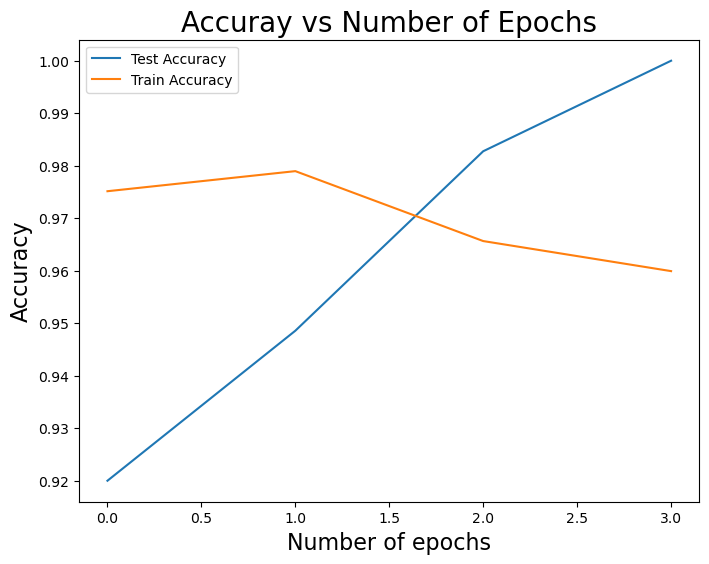

In [19]:
model.plot_accuracy()

# Plot Confusion Matrix

In [20]:
def plot_confusion_matrix(y_test, y_pred, classes, cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title= 'Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

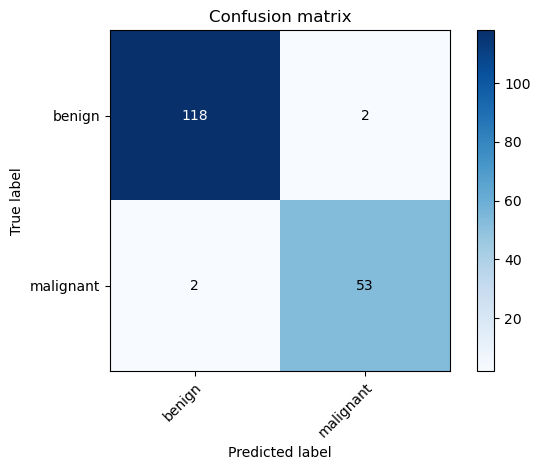

In [21]:
from sklearn.metrics import confusion_matrix
model = ANN(layers=[9, 4, 1], learning_rate=0.0001, max_iter=10000) # create the NN model
model.fit(X_test, y_test) #test the model
y_pred = model.predict(X_test)
class_names = ['benign', 'malignant']
plot_confusion_matrix(y_test, y_pred, classes=class_names)